# Band combination and true color adjustment

Dans ce notebook nous allons examiner comment récupérer une image en "couleurs réelles" à partir dans bandes fournies par le satellite Landsat 8. Le principe serait le même pour tout autre satellite multispectral.

Nous allons voir qu'on ne peut pas se contenter d'associer les bandes rouge, verte et bleues. En effet, le résultat est très sombre. Il faut donc appliquer quelques modifications pour obtenir une image lisible par un être humain. Nous allons donc appliquer : 

1) Egalisation d'histogramme.
2) Correction gamma.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import nbimporter
from utils import pansharpening as utils

## Chargement des images

Commençons par charger les images.

In [2]:
#path = '../images/landsat_9/lyon/LC08_L1TP_196028_20220520_20220520_02_RT_'
path = '../images/landsat_9/lausanne/LC09_L1TP_195028_20220419_20220419_02_T1_'
ext = '.TIF'

In [3]:
blue = cv2.imread(path + 'B2' + ext, cv2.IMREAD_GRAYSCALE)
green = cv2.imread(path + 'B3' + ext, cv2.IMREAD_GRAYSCALE)
red = cv2.imread(path + 'B4' + ext, cv2.IMREAD_GRAYSCALE)
rgb = cv2.merge((red, green, blue))

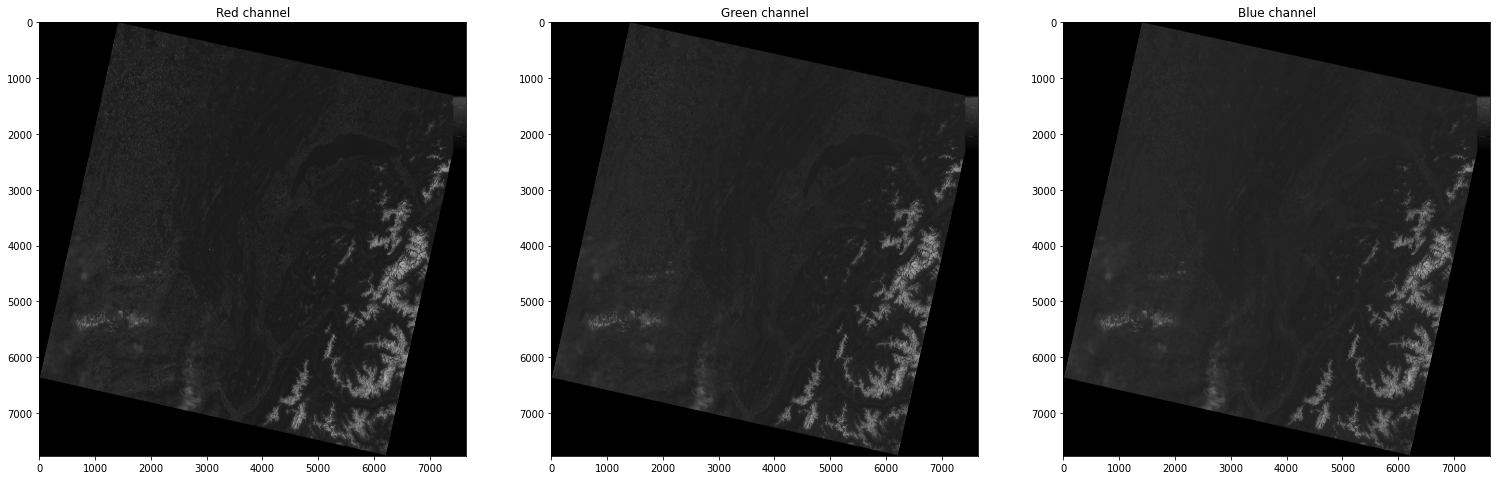

In [3]:
utils.plot_list([red, green, blue], ['Red channel', 'Green channel', 'Blue channel'])

On peut voir que des artefacts apparaissent dans le coin supérieur droit. Après quelques investigations nous avons retrouvé la source du problème :

In [4]:
!identify -quiet '../images/landsat_9/lyon/LC08_L1TP_196028_20220520_20220520_02_RT_B4.TIF'

../images/landsat_9/lyon/LC08_L1TP_196028_20220520_20220520_02_RT_B4.TIF[0] TIFF 7651x7771 7651x7771+0+0 16-bit Grayscale Gray 89.6434MiB 0.950u 0:00.961
../images/landsat_9/lyon/LC08_L1TP_196028_20220520_20220520_02_RT_B4.TIF[1] TIFF 3826x3886 3826x3886+0+0 16-bit Grayscale Gray 0.240u 0:00.247
../images/landsat_9/lyon/LC08_L1TP_196028_20220520_20220520_02_RT_B4.TIF[2] TIFF 1913x1943 1913x1943+0+0 16-bit Grayscale Gray 0.070u 0:00.065
../images/landsat_9/lyon/LC08_L1TP_196028_20220520_20220520_02_RT_B4.TIF[3] TIFF 957x972 957x972+0+0 16-bit Grayscale Gray 0.010u 0:00.017
../images/landsat_9/lyon/LC08_L1TP_196028_20220520_20220520_02_RT_B4.TIF[4] TIFF 479x486 479x486+0+0 16-bit Grayscale Gray 0.000u 0:00.005
../images/landsat_9/lyon/LC08_L1TP_196028_20220520_20220520_02_RT_B4.TIF[5] TIFF 240x243 240x243+0+0 16-bit Grayscale Gray 0.000u 0:00.003
../images/landsat_9/lyon/LC08_L1TP_196028_20220520_20220520_02_RT_B4.TIF[6] TIFF 120x122 120x122+0+0 16-bit Grayscale Gray 0.000u 0:00.002


En utilisant `identify` de ImageMagick, on peut voir que les couleurs de notre images sont décrites sur 16 bits...

In [5]:
red.shape, red.dtype

((7771, 7651), dtype('uint8'))

... mais nous avons lu celle-ci sur 8 bits !

Afin d'éviter ces artefacts et de profiter de toutes les informations que nous offre l'image satellite, nous allons lire l'image avec une profonduer 16 bits.

In [3]:
blue_16 = cv2.imread(path + 'B2' + ext, cv2.IMREAD_ANYDEPTH)
green_16 = cv2.imread(path + 'B3' + ext, cv2.IMREAD_ANYDEPTH)
red_16 = cv2.imread(path + 'B4' + ext, cv2.IMREAD_ANYDEPTH)
rgb_16 = cv2.merge((red_16, green_16, blue_16))

In [4]:
red_16.shape, red_16.dtype

((8011, 7911), dtype('uint16'))

Je n'arrive pas à faire fonctionner `vmax` de `matplotlib.pyplot.imshow()` donc je divise l'image par 256 pour obtenir une image sur 8 bits pour l'affichage.

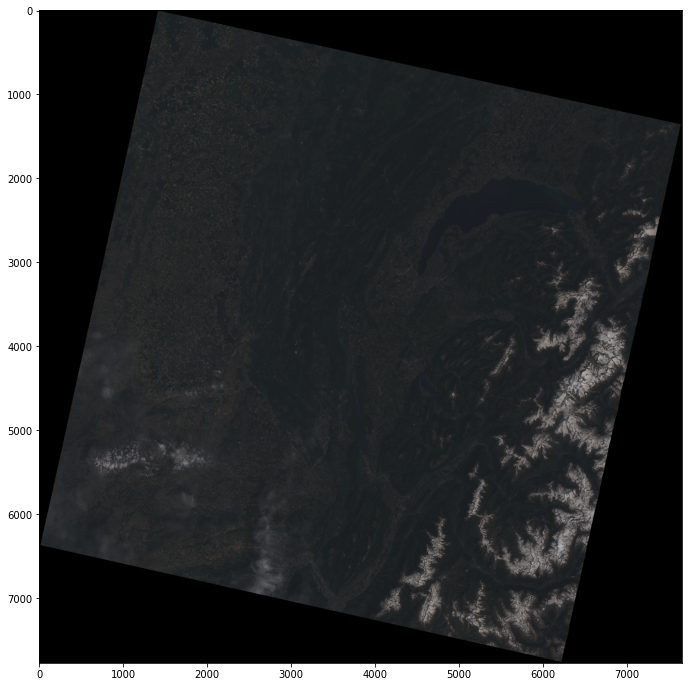

In [8]:
utils.display_img(rgb_16 // 256)

Comme expliqué dans l'introduction, l'image est très sombre. Hormis le blanc des nuages (à gauche) et des glaciers (à droite) on ne distingue pas grand chose. 

On peut d'ailleurs la comparer à l'image panchromatique :

In [5]:
pan = cv2.imread(path + 'B8' + ext, cv2.IMREAD_ANYDEPTH)

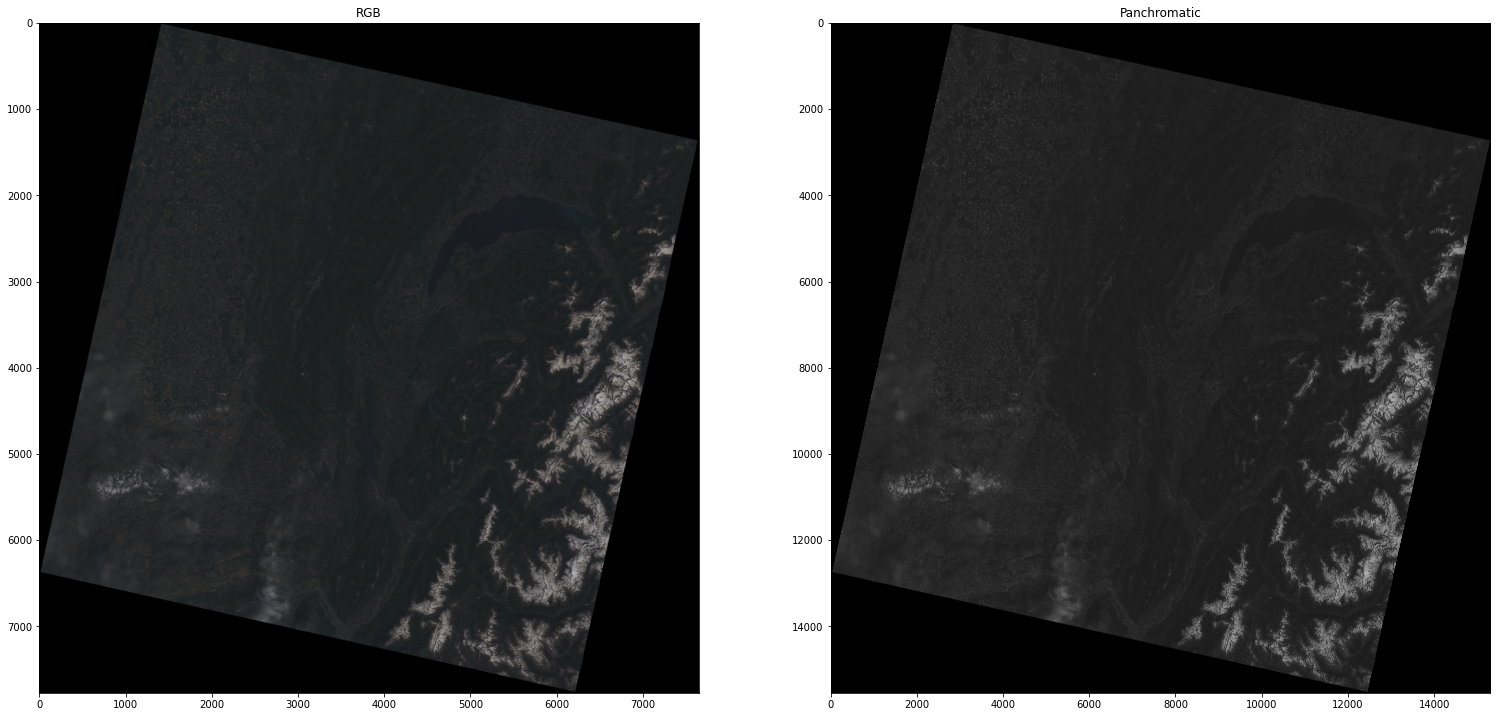

In [13]:
utils.plot_list([rgb_16 // 256, pan], ['RGB', 'Panchromatic'])

On ne distingue pratiquement pas plus les couleurs sur l'image colorée que sur l'image panchromatique !

Nous allons donc essayer d'amélirorer tout ça. Commençons par expliciter la source du problème.

## Create mask

Nous créons un masque pour ne pas prendre en compte les pixels totalement noirs.

In [14]:
def mask(img):
    mask = img.sum(axis=2) > 0
    return mask

In [15]:
rgb_mask = mask(rgb_16)

In [16]:
rgb_mask.shape

(7771, 7651)

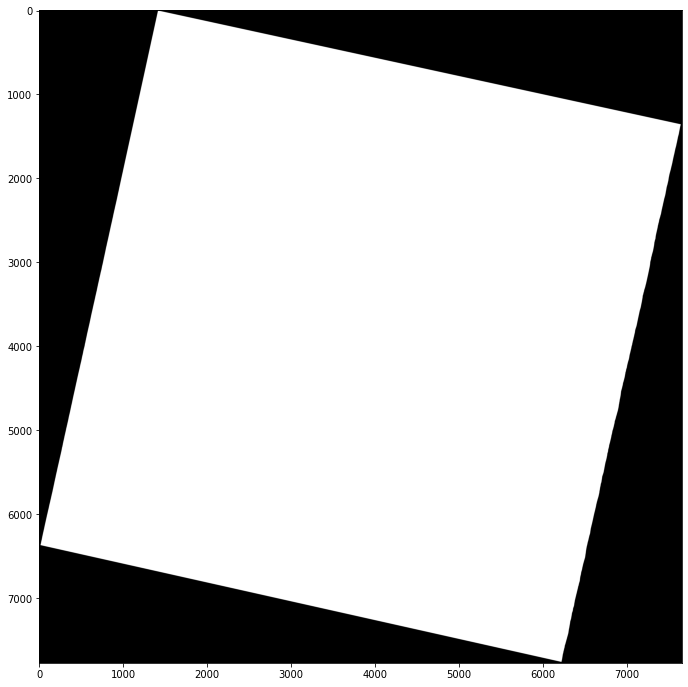

In [17]:
utils.display_img(rgb_mask)

## Histograms

Affichons l'histogramme de notre image.

In [153]:
def plot_hist(img, mask, depth):
    histSize = 2**depth
    ranges = [0, histSize]
    colors = ("r", "g", "b")

    max_value = 0

    for i, col in enumerate(colors):
        histogram = cv2.calcHist(
            [img], [i], mask.astype(np.uint8), histSize=[histSize], ranges=ranges
        )
        plt.plot(histogram, color=col)
        plt.title("Hisogram")
        plt.xlim(ranges)

        max_value = max(max_value, histogram.max())

    print("Max value:", max_value)
    plt.show()
    return max_value


Max value: 20756.0


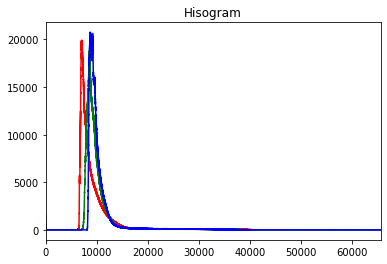

In [154]:
max_value_16 = plot_hist(rgb_16, rgb_mask, 16)

On peut voir que la majorité des couleurs sont concentrées dans le tiers le plus faible de notre plage de valeurs (0 à 65535 puisque nous sommes sur 16 bits). Ce qui explique que notre image est très sombre.

Max value: 5063408.0


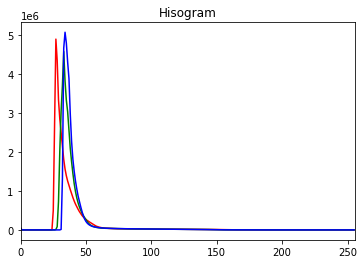

In [155]:
max_value = plot_hist(rgb, rgb_mask, 8)

In [36]:
max_value / max_value_16

243.94913

On peut aussi voir l'avantage d'utiliser l'image en 16 bits. Les courbes sont similaires mais le nombre d'occurences de la valeur la plus représentée est 243 fois supérieur sur l'image 8 bits. Cela fait sens puisque la plage de valeurs est 256 fois plus petites.

Cette différence va avoir son importance pour l'égalisation d'histogramme.

## Equalization

### Classic

In [45]:
red_eq = cv2.equalizeHist(red)
green_eq = cv2.equalizeHist(green)
blue_eq = cv2.equalizeHist(blue)

rgb_eq = cv2.merge((red_eq, green_eq, blue_eq))

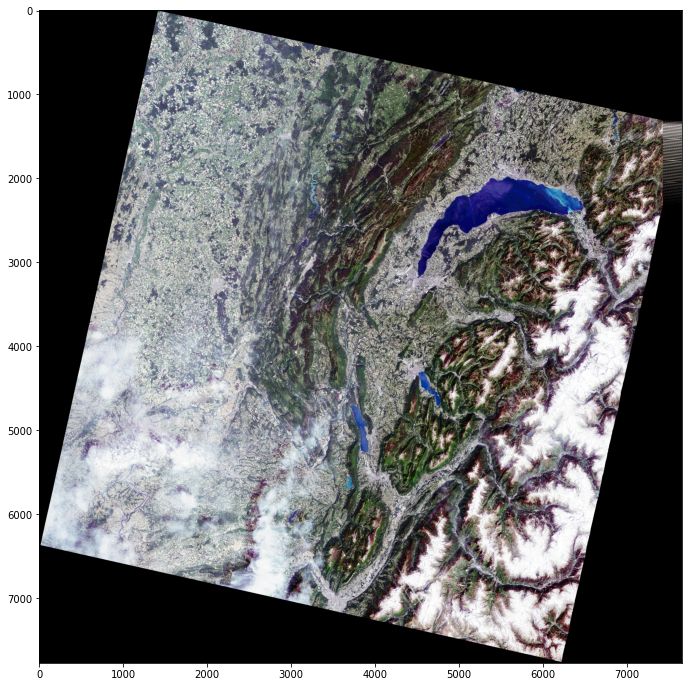

In [46]:
utils.display_img(rgb_eq)

Max value: 5063408.0


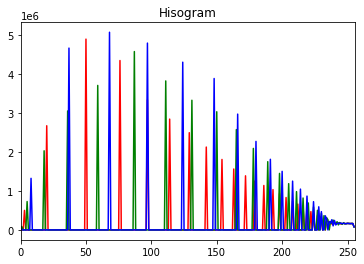

5063408.0

In [47]:
plot_hist(rgb_eq, 8)

L'égalisateur d'histogram classique d'openCV n'accepte que des images avec une profondeur de 8 bits et ne permet pas d'appliquer un masque. Les résultats pour notre problème sont catastrophiques.

Définissons notre fonction d'égalisation d'histogramme afin de pouvoir comparé les résultats entre l'image 8 et 16 bits.

In [193]:
def image_histogram_equalization(img, mask, depth):
    nb_of_bins = 2**depth
    
    # get image histogram
    hist, bins = np.histogram(img[mask].flatten(), nb_of_bins, density=True)

    cdf = hist.cumsum() # cumulative distribution function
    cdf = (nb_of_bins - 1) * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    img_eq = np.zeros_like(img)
    img_eq[mask] = np.interp(img[mask].flatten(), bins[:-1], cdf)
    hist_eq, bins = np.histogram(img_eq[mask].flatten(), nb_of_bins, density=True)
    cdf_eq = hist_eq.cumsum() # cumulative distribution function
    cdf_eq = (nb_of_bins - 1) * cdf_eq / cdf_eq[-1] # normalize

    return hist, hist_eq, img_eq.reshape(img.shape), cdf, cdf_eq

On reproduit le résultat sur l'image 8 bits afin de pouvoir comparer.

In [194]:
hist, hist_eq, red_eq, cdf, cdf_eq = image_histogram_equalization(red, rgb_mask, 8)

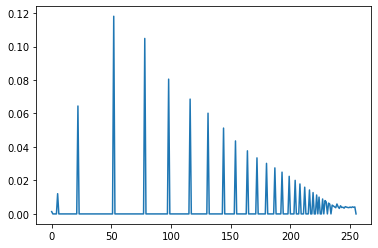

In [195]:
plt.plot(hist_eq)

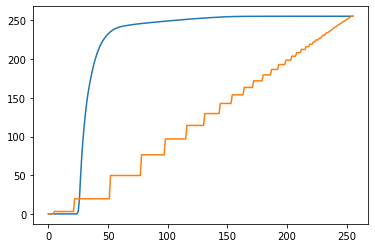

In [207]:
plt.plot(cdf, label='Cumulative hist before')
plt.plot(cdf_eq, label='Cumulative hist after 8 bit equalization')

In [196]:
hist_16, hist_16_eq, red_16_eq, cdf_16, cdf_16_eq = image_histogram_equalization(red_16, rgb_mask, 16)
_, _, green_16_eq, _, _ = image_histogram_equalization(green_16, rgb_mask, 16)
_, _, blue_16_eq, _, _ = image_histogram_equalization(blue_16, rgb_mask, 16)

In [197]:
rgb_16_eq = cv2.merge((red_16_eq, green_16_eq, blue_16_eq))

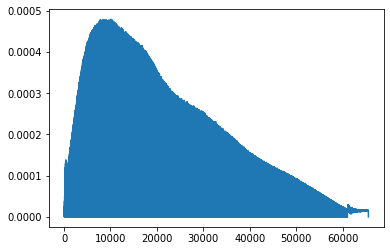

In [198]:
plt.plot(hist_16_eq)

Max value: 179002.0


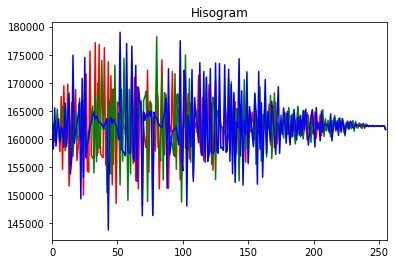

179002.0

In [199]:
plot_hist(rgb_16_eq // 256, rgb_mask, 8)

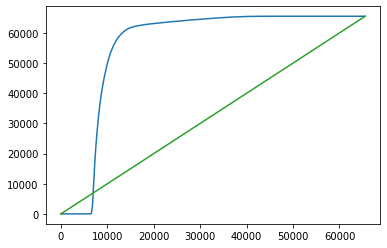

In [206]:
plt.plot(cdf_16, label='Cumulative hist before')
plt.plot(cdf_16_eq, label='Cumulative hist after 16 bit equalization')

Sans surprise, l'égalisation est bien meilleure avec l'image 16 bits car les données sont réparties sur un plus grand nombre de valeur et l'histogramme cumulatif résultant est donc bien plus linéaire.

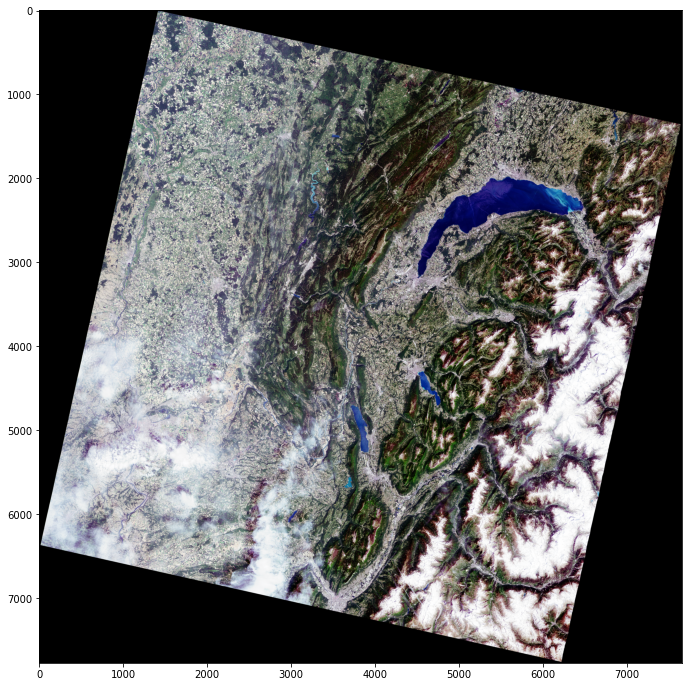

In [209]:
utils.display_img(rgb_16_eq // 256)

Cependant, l'image elle est toujours aussi mauvaise.



### CLAHE

In [6]:
clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8, 8))

In [7]:
red_16_eq_cl = clahe.apply(red_16)
green_16_eq_cl = clahe.apply(green_16)
blue_16_eq_cl = clahe.apply(blue_16)

rgb_16_eq_cl = cv2.merge((red_16_eq_cl, green_16_eq_cl, blue_16_eq_cl))

Max value: 3529.0


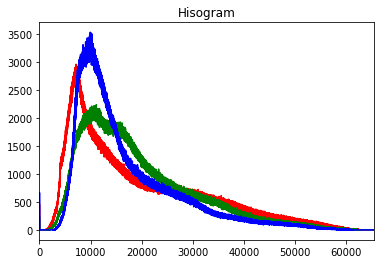

3529.0

In [251]:
plot_hist(rgb_16_eq_cl, rgb_mask, 16)

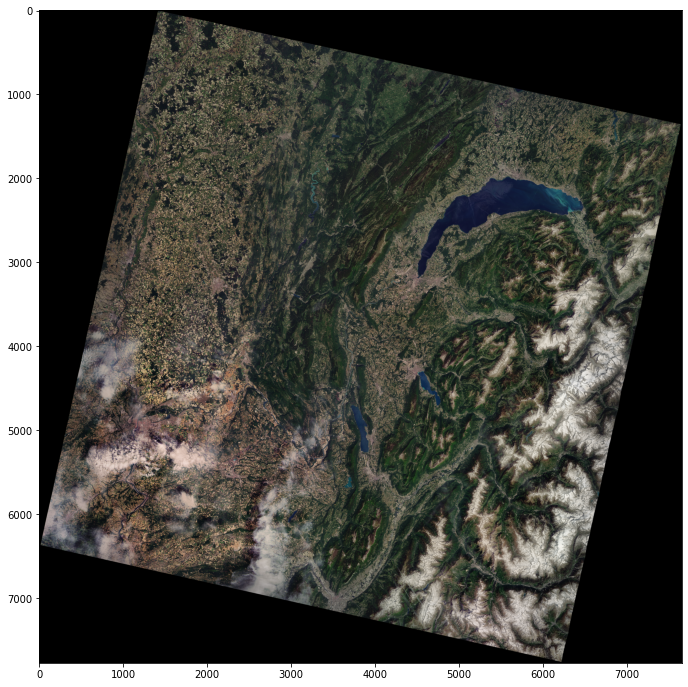

In [252]:
utils.display_img(rgb_16_eq_cl // 256)

In [8]:
pan_eq_cl = clahe.apply(pan)

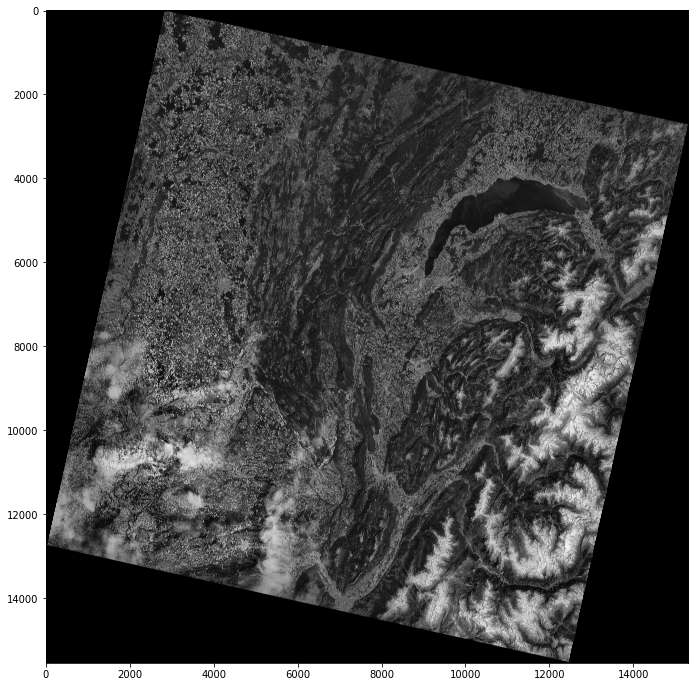

In [6]:
utils.display_img(pan_eq_cl // 256)

## Save results

In [9]:
def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

In [11]:
cv2.imwrite(path + 'RGB' + ext, bgr(rgb_16_eq_cl))

True

In [12]:
cv2.imwrite(path + 'PAN' + ext, pan_eq_cl)

True